In [ ]:
import pandas as pd

# Загрузка тренировочной выборки
train_data_path = './train_spam.csv'
train_data = pd.read_csv(train_data_path)

# Основная информация о выборке
train_info = train_data.info()
train_head = train_data.head()
train_describe = train_data.describe(include='all')

train_info, train_head, train_describe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16278 entries, 0 to 16277
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text_type  16278 non-null  object
 1   text       16278 non-null  object
dtypes: object(2)
memory usage: 254.5+ KB


(None,
   text_type                                               text
 0       ham  make sure alex knows his birthday is over in f...
 1       ham  a resume for john lavorato thanks vince i will...
 2      spam  plzz visit my website moviesgodml to get all m...
 3      spam  urgent your mobile number has been awarded wit...
 4       ham  overview of hr associates analyst project per ...,
        text_type                                               text
 count      16278                                              16278
 unique         2                                              16267
 top          ham  SPAM ALERT  🚔  User:     Username: @DillyBubbl...
 freq       11469                                                  7)

Тренировочная выборка содержит 16278 объектов и 2 столбца:

text_type — целевая переменная, показывающая, является ли сообщение СПАМом или нет. Таргет имеет 2 уникальных значения: 'ham' (не СПАМ) и 'spam' (СПАМ).

text — текст сообщения. Большая часть текстов уникальны (16267 из 16278). Пустых текстов нет.

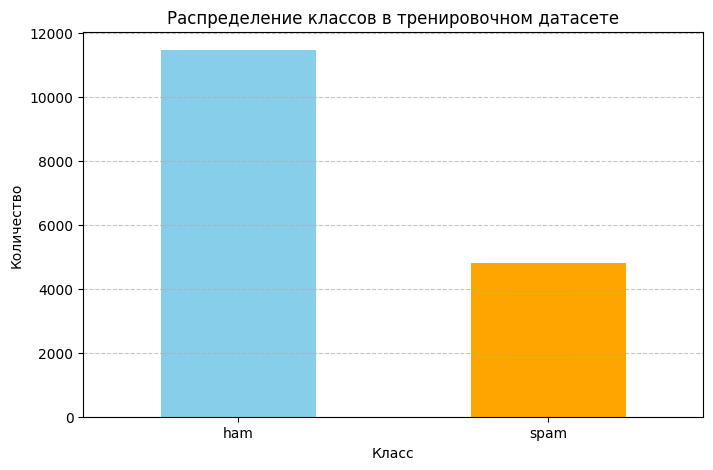

text_type
ham     11469
spam     4809
Name: count, dtype: int64

In [ ]:
import matplotlib.pyplot as plt

# Подсчет количества записей для каждого класса
class_distribution = train_data['text_type'].value_counts()

# Визуализация распределения классов
plt.figure(figsize=(8, 5))
class_distribution.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Распределение классов в тренировочном датасете')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

class_distribution


Выборка несбалансирована: сообщений 'ham' более чем в два раза больше, чем сообщений 'spam'. Для сохранения соотношения между классами при разбиении на тренировочную и валидационную выборки будет использована стратификация.

In [ ]:
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

def preprocess_text(text):
    # Удаление специальных символов
    text = re.sub(r'\W+',' ', text)
    # Приведение всех символов к нижнему регистру
    text = text.lower()
    return text

# Применение функции предобработки ко всем текстам в выборке
train_data['clean_text'] = train_data['text'].apply(preprocess_text)

# Векторизация текстов с использованием TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(train_data['clean_text'])
y = train_data['text_type'].apply(lambda x: 1 if x == 'spam' else 0)

# Разбиение данных на тренировочную и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Вывод результатов предобработки
train_data.head(), X_train.shape, X_val.shape


(  text_type                                               text  \
 0       ham  make sure alex knows his birthday is over in f...   
 1       ham  a resume for john lavorato thanks vince i will...   
 2      spam  plzz visit my website moviesgodml to get all m...   
 3      spam  urgent your mobile number has been awarded wit...   
 4       ham  overview of hr associates analyst project per ...   
 
                                           clean_text  
 0  make sure alex knows his birthday is over in f...  
 1  a resume for john lavorato thanks vince i will...  
 2  plzz visit my website moviesgodml to get all m...  
 3  urgent your mobile number has been awarded wit...  
 4  overview of hr associates analyst project per ...  ,
 (13022, 53378),
 (3256, 53378))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score


# Создание моделей
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100)
}

# Обучение моделей и оценка их производительности на валидационной выборке
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)  # Обучение модели
    y_pred_proba = model.predict_proba(X_val)[:, 1]  # Расчет вероятностей для класса "spam"
    auc_score = roc_auc_score(y_val, y_pred_proba)  # Расчет ROC-AUC
    results[name] = auc_score

results


{'Logistic Regression': 0.9766483840154284,
 'Naive Bayes': 0.9439145234698854,
 'Random Forest': 0.9809418767570467,
 'Gradient Boosting': 0.9479791809783091}

Видно, что случайный лес показывает наилучшую предсказательную способность на целевой метрике ROC-AUC.

In [ ]:
# Загрузка тестовой выборки
test_data_path = './test_spam.csv'
test_data = pd.read_csv(test_data_path)

# Применение функции предобработки ко всем текстам в тестовой выборке
test_data['clean_text'] = test_data['text'].apply(preprocess_text)

# Векторизация текстов тестовой выборки с использованием того же TF-IDF векторизатора
X_test = tfidf_vectorizer.transform(test_data['clean_text'])

# Информация о тестовой выборке и размер векторизированных данных
test_data.head(), X_test.shape


(                                                text  \
 0  j jim whitehead ejw cse ucsc edu writes j you ...   
 1  original message from bitbitch magnesium net p...   
 2  java for managers vince durasoft who just taug...   
 3               there is a youtuber name saiman says   
 4  underpriced issue with high return on equity t...   
 
                                           clean_text  
 0  j jim whitehead ejw cse ucsc edu writes j you ...  
 1  original message from bitbitch magnesium net p...  
 2  java for managers vince durasoft who just taug...  
 3               there is a youtuber name saiman says  
 4  underpriced issue with high return on equity t...  ,
 (4070, 53378))

In [ ]:
# Расчет вероятностей для тестовой выборки
best_model = models["Random Forest"]
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Создание датафрейма с результатами
results_df = pd.DataFrame({
    'text': test_data['text'],
    'score': y_test_pred_proba
})

# Сохранение результатов в CSV-файл
results_path = './spam_predictions.csv'
results_df.to_csv(results_path, index=False)

results_df.head(), results_path


(                                                text     score
 0  j jim whitehead ejw cse ucsc edu writes j you ...  0.130000
 1  original message from bitbitch magnesium net p...  0.210000
 2  java for managers vince durasoft who just taug...  0.020000
 3               there is a youtuber name saiman says  0.010769
 4  underpriced issue with high return on equity t...  0.700000,
 './spam_predictions.csv')